In [45]:
!pip install pandas folium numpy seaborn 

In [39]:
!pip install dash


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [47]:
!pip install keplergl

In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('signals.csv')

print("📊 --- Columns Overview ---")
print(df.columns.tolist())

print("\n🔍 --- Data Types ---")
print(df.dtypes)

print("\n📦 --- Sample Data (first 5 rows) ---")
print(df.head())

print("\n📏 --- Dataset Shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n🧱 --- Null Value Check ---")
print(df.isnull().sum())

print("\n🎯 --- Unique Value Counts ---")
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")

print("\n🚦 --- Constant Columns (Only 1 Unique Value) ---")
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(constant_cols if constant_cols else "None")

print("\n🧪 --- Column-wise Summary ---")
for col in df.columns:
    print(f"\n🔸 Column: {col}")
    if pd.api.types.is_numeric_dtype(df[col]):
        print(df[col].describe())
    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        print("Date Range:", df[col].min(), "to", df[col].max())
    else:
        print(df[col].value_counts().head(10))

print("\n🧠 --- Memory Usage ---")
print(df.memory_usage(deep=True).sort_values(ascending=False))

print("\n✅ --- Done Analyzing signals.csv ---")


📊 --- Columns Overview ---
['Date', 'ConnType', 'Longitude', 'Latitude', 'Freq Band Indicator', 'Physical Cell ID', 'Measured RSSI', 'Measured RSRP', 'Measured RSRQ', 'Download speed', 'Download size', 'Upload speed', 'Upload size', 'Latency', 'Altitude', 'GPS coordinates', 'Geo location']

🔍 --- Data Types ---
Date                    object
ConnType                object
Longitude              float64
Latitude               float64
Freq Band Indicator      int64
Physical Cell ID         int64
Measured RSSI          float64
Measured RSRP          float64
Measured RSRQ          float64
Download speed         float64
Download size          float64
Upload speed           float64
Upload size            float64
Latency                 object
Altitude                 int64
GPS coordinates         object
Geo location            object
dtype: object

📦 --- Sample Data (first 5 rows) ---
               Date ConnType  Longitude   Latitude  Freq Band Indicator  \
0  01/03/2022 14:30       3G  -6.

In [85]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load the data
df = pd.read_csv("signals.csv")

# Convert Latency from string to numeric (removing " ms" and converting to float)
df['Latency_Numeric'] = df['Latency'].str.replace(' ms', '').astype(float)

# Create base map centered at the mean coordinates
m = folium.Map(
    location=[df['Latitude'].mean(), df['Longitude'].mean()],
    zoom_start=14,
    tiles='OpenStreetMap'
)

# Define the metrics we want to visualize
metrics = {
    'Measured RSSI': 'Signal Strength (RSSI)',
    'Measured RSRP': 'Signal Power (RSRP)',
    'Measured RSRQ': 'Signal Quality (RSRQ)',
    'Download speed': 'Download Speed',
    'Upload speed': 'Upload Speed',
    'Latency_Numeric': 'Latency (ms)',
    'Altitude': 'Altitude (m)'
}

# Store all feature groups in a dictionary so we can reference them later
heatmap_layers = {}

# Create a separate map for each metric
for column, title in metrics.items():
    # Create a new feature group for this metric with show=False for all
    fg = folium.FeatureGroup(name=title, show=False)
    
    # Prepare data for heatmap
    heat_data = []
    for _, row in df.iterrows():
        try:
            lat = float(row['Latitude'])
            lon = float(row['Longitude'])
            
            # For latency, lower is better, so we invert the value
            if column == 'Latency_Numeric':
                weight = 60 - float(row[column])
            else:
                weight = float(row[column])
                
            heat_data.append([lat, lon, weight])
        except (ValueError, TypeError):
            continue
    
    # Create a simple heatmap with minimal options
    HeatMap(
        heat_data,
        radius=15,
        blur=10,
        min_opacity=0.5
    ).add_to(fg)
    
    # Add the layer to the map (all hidden initially)
    fg.add_to(m)
    
    # Store reference to this feature group
    heatmap_layers[title] = fg

# Manually make only the RSSI layer visible (after all layers are added)
for name, fg in heatmap_layers.items():
    if 'RSSI' in name:
        for child in fg._children.values():
            child.show = True
        fg.show = True
        break

# Add a legend for signal metrics
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px; border-radius: 5px;">
     <h4 style="margin-top: 0;">Signal Intensity</h4>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
       <div style="flex: 1; height: 20px; background: linear-gradient(to right, blue, lime, yellow, red);"></div>
     </div>
     <div style="display: flex; justify-content: space-between;">
       <div>Low</div>
       <div>High</div>
     </div>
     <p style="margin-bottom: 0; margin-top: 10px;">Use the layer control to switch metrics</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add altitude markers - smaller and more discreet
fg_altitude_markers = folium.FeatureGroup(name="Altitude Markers", show=False)

# Add a marker for each unique data point
unique_locations = df.drop_duplicates(subset=['Latitude', 'Longitude'])
for _, row in unique_locations.iterrows():
    # Create popup content with altitude info prominently displayed
    popup_text = f"""
    <div style="min-width: 180px;">
        <h4 style="margin-top: 0; text-align: center;">Altitude: {row['Altitude']}m</h4>
        <hr style="margin: 8px 0;">
        <b>Connection:</b> {row['ConnType']}<br>
        <b>RSSI:</b> {row['Measured RSSI']}<br>
        <b>RSRP:</b> {row['Measured RSRP']}<br>
        <b>RSRQ:</b> {row['Measured RSRQ']}<br>
        <b>Download:</b> {row['Download speed']} Mbps<br>
        <b>Upload:</b> {row['Upload speed']} Mbps<br>
        <b>Latency:</b> {row['Latency']}<br>
        <b>Location:</b> {row['Geo location']}<br>
    </div>
    """
    
    # Create a smaller, more discreet circle marker
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,                     # Smaller radius (was 12)
        color='#8a2be2',              # More subtle purple color
        fill=True,
        fill_opacity=0.5,             # More transparent
        weight=1,                     # Thinner border
        popup=folium.Popup(popup_text, max_width=250),
        tooltip=f"Alt: {row['Altitude']}m"  # Shorter tooltip
    ).add_to(fg_altitude_markers)

# Add the altitude markers layer to the map
fg_altitude_markers.add_to(m)

# Add connection type markers (colored by connection type)
for conn_type in df['ConnType'].unique():
    fg = folium.FeatureGroup(name=f"Connection Type: {conn_type}", show=False)
    
    # Filter for this connection type
    conn_df = df[df['ConnType'] == conn_type]
    
    # Choose color based on connection type
    if conn_type == '5G':
        color = 'red'
    elif conn_type == 'LTE':
        color = 'blue'
    else:  # 3G
        color = 'gray'
    
    # Add a marker for each point
    for _, row in conn_df.iterrows():
        popup_text = f"""
        <b>Connection:</b> {row['ConnType']}<br>
        <b>Altitude:</b> {row['Altitude']}m<br>
        <b>RSSI:</b> {row['Measured RSSI']}<br>
        <b>RSRP:</b> {row['Measured RSRP']}<br>
        <b>RSRQ:</b> {row['Measured RSRQ']}<br>
        <b>Download:</b> {row['Download speed']} Mbps<br>
        <b>Upload:</b> {row['Upload speed']} Mbps<br>
        <b>Latency:</b> {row['Latency']}<br>
        """
        
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=250),
            tooltip=f"{conn_type} - Alt: {row['Altitude']}m"
        ).add_to(fg)
    
    # Add this connection type layer (hidden by default)
    fg.add_to(m)

# Add a simple title
title_html = '''
<div style="position: fixed; 
     top: 10px; left: 50px; width: 300px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px; border-radius: 5px;">
     <h3 style="margin-top: 0;">Mobile Network Signal Heatmap</h3>
     <p style="margin-bottom: 0;">Toggle layers in the control panel →</p>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Add JavaScript to ensure only one heatmap layer is visible at a time
js_code = """
<script type="text/javascript">
document.addEventListener('DOMContentLoaded', function() {
    // Get all heatmap layer controls (checkboxes)
    var heatmapLayers = [];
    var layerControls = document.querySelectorAll('.leaflet-control-layers-overlays input[type="checkbox"]');
    
    // Identify and store references to the heatmap layer checkboxes
    layerControls.forEach(function(checkbox) {
        var label = checkbox.nextSibling.textContent.trim();
        if (label.includes('Signal') || label.includes('Download') || label.includes('Upload') || 
           label.includes('Latency') || label.includes('Altitude (m)')) {
            heatmapLayers.push({
                label: label,
                checkbox: checkbox
            });
            
            // Make sure all are unchecked initially
            checkbox.checked = false;
        }
    });
    
    // Only check the RSSI checkbox initially
    for (var i = 0; i < heatmapLayers.length; i++) {
        if (heatmapLayers[i].label.includes('RSSI')) {
            // Check this one
            heatmapLayers[i].checkbox.checked = true;
            break;
        }
    }
    
    // Add click event listeners to each heatmap layer checkbox
    heatmapLayers.forEach(function(layer) {
        layer.checkbox.addEventListener('change', function(e) {
            if (e.target.checked) {
                // If this layer is being turned on, turn off all other heatmap layers
                heatmapLayers.forEach(function(otherLayer) {
                    if (otherLayer.label !== layer.label && otherLayer.checkbox.checked) {
                        otherLayer.checkbox.checked = false;
                        
                        // Need to trigger the layer control's change event
                        var event = new Event('change');
                        otherLayer.checkbox.dispatchEvent(event);
                    }
                });
            }
        });
    });
});
</script>
"""
m.get_root().html.add_child(folium.Element(js_code))

# Add layer control
folium.LayerControl().add_to(m)

# Save and display the map
m.save('interactive_signal_heatmap.html')
m

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from ipywidgets import interact, Dropdown

# Load data
df = pd.read_csv("signals.csv")

# Convert Latency from string to numeric
df['Latency_Numeric'] = df['Latency'].str.replace(' ms', '').astype(float)

# Define the metrics we want to visualize (removed 'Altitude')
metrics = {
    'Measured RSSI': 'Signal Strength (RSSI)',
    'Measured RSRP': 'Signal Power (RSRP)',
    'Measured RSRQ': 'Signal Quality (RSRQ)',
    'Download speed': 'Download Speed (Mbps)',
    'Upload speed': 'Upload Speed (Mbps)',
    'Latency_Numeric': 'Latency (ms)'
}

# Create plotting function that will be called for each variable
def plot_signal_data(variable='Measured RSSI'):
    plt.figure(figsize=(10, 8))
    
    x = df['Longitude']
    y = df['Latitude']
    
    # For latency, lower is better, so invert
    if variable == 'Latency_Numeric':
        z = 60 - df[variable]
        colorbar_label = 'Better Signal ←→ Worse Signal'
    else:
        z = df[variable]
        colorbar_label = metrics.get(variable, variable)
    
    # Create grid and interpolate
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Create contour plot
    contour = plt.contourf(xi, yi, zi, 15, cmap='jet')
    plt.colorbar(label=colorbar_label)
    
    # Add points for different connection types with consistent colors
    for conn_type, marker, color in [('3G', 'o', 'gray'), ('5G', '^', 'red'), ('LTE', 's', 'blue')]:
        subset = df[df['ConnType'] == conn_type]
        plt.scatter(subset['Longitude'], subset['Latitude'], 
                   marker=marker, s=30, edgecolor='black', 
                   facecolor=color, alpha=0.7, label=conn_type)
    
    # Removed altitude marker logic completely

    plt.title(f'Mobile Network: {metrics.get(variable, variable)}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Connection Type')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Interactive widget or default plot
if 'get_ipython' in globals():
    variable_dropdown = Dropdown(
        options=list(metrics.keys()),
        value='Measured RSSI',
        description='Variable:',
        style={'description_width': 'initial'}
    )
    interact(plot_signal_data, variable=variable_dropdown)
else:
    plot_signal_data('Measured RSSI')


interactive(children=(Dropdown(description='Variable:', options=('Measured RSSI', 'Measured RSRP', 'Measured R…

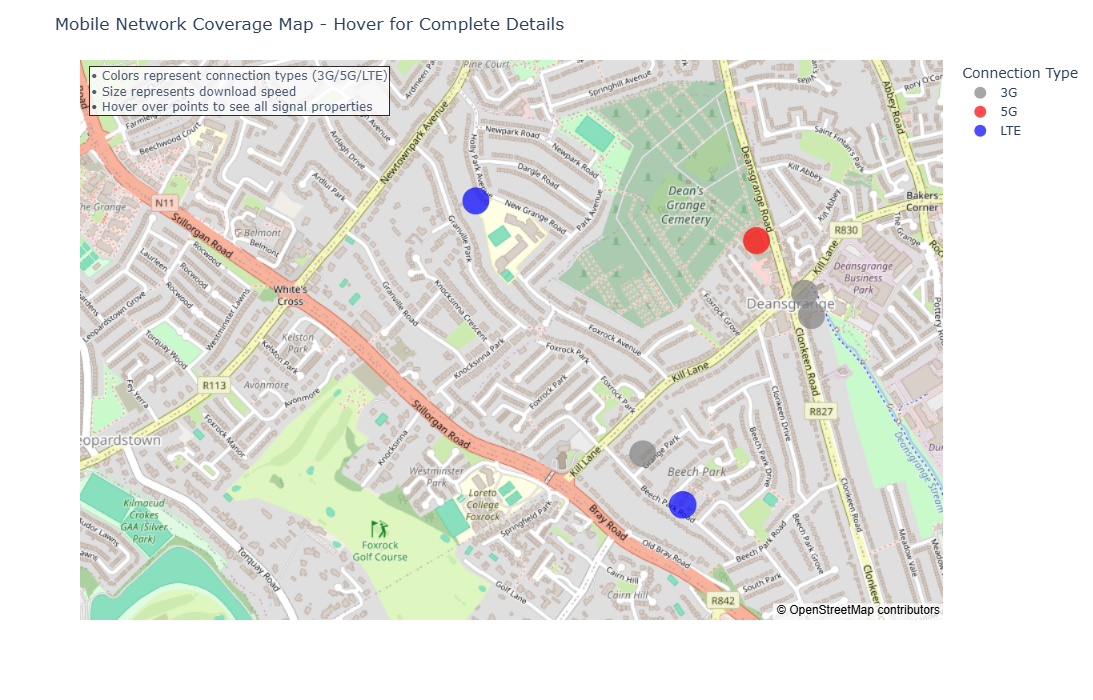

In [87]:
import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("signals.csv")

# Convert Latency from string to numeric
df['Latency_Numeric'] = df['Latency'].str.replace(' ms', '').astype(float)

# Create a comprehensive visualization with all properties shown on hover
fig = px.scatter_mapbox(
    df, 
    lat='Latitude',
    lon='Longitude',
    # Color points by connection type for clear visual grouping
    color='ConnType',
    # Size points by download speed to show performance
    size='Download speed',
    # Use a color scheme that differentiates well
    color_discrete_map={'3G': 'gray', '5G': 'red', 'LTE': 'blue'},
    # Include ALL properties in hover data
    hover_data={
        'ConnType': True,
        'Measured RSSI': True,
        'Measured RSRP': True,
        'Measured RSRQ': True,
        'Download speed': True,
        'Upload speed': True,
        'Latency': True,
        'Altitude': True,
        'Freq Band Indicator': True,
        'Physical Cell ID': True,
        'Date': True,
        'Geo location': True,
        'Latitude': False,  # Hide these as they're shown as coordinates
        'Longitude': False
    },
    # Add custom labels
    labels={
        'ConnType': 'Connection Type',
        'Measured RSSI': 'Signal Strength (RSSI)',
        'Measured RSRP': 'Signal Power (RSRP)',
        'Measured RSRQ': 'Signal Quality (RSRQ)',
        'Download speed': 'Download Speed (Mbps)',
        'Upload speed': 'Upload Speed (Mbps)',
        'Latency': 'Latency',
        'Altitude': 'Altitude (m)',
        'Freq Band Indicator': 'Frequency Band',
        'Physical Cell ID': 'Cell ID',
        'Date': 'Date'
    },
    zoom=14
)

# Update layout
fig.update_layout(
    title='Mobile Network Coverage Map - Hover for Complete Details',
    mapbox_style="open-street-map",
    height=700,
    # Add helpful text explanation
    annotations=[
        dict(
            text="• Colors represent connection types (3G/5G/LTE)<br>• Size represents download speed<br>• Hover over points to see all signal properties",
            align="left",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0.01,
            y=0.99,
            bordercolor="black",
            borderwidth=1,
            bgcolor="white",
            opacity=0.8
        )
    ]
)

# Update hover template to make it more readable
for trace in fig.data:
    trace.hovertemplate = trace.hovertemplate.replace("<br>", "<br><b>").replace(":", ":</b>")

# Show the figure
fig.show()

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import ipywidgets as widgets
from IPython.display import display

# Load data
df = pd.read_csv("signals.csv")

# Convert Latency from string to numeric
df['Latency_Numeric'] = df['Latency'].str.replace(' ms', '').astype(float)

# Define the metrics we want to visualize
metrics = {
    'Measured RSSI': 'Signal Strength (RSSI)',
    'Measured RSRP': 'Signal Power (RSRP)',
    'Measured RSRQ': 'Signal Quality (RSRQ)',
    'Download speed': 'Download Speed (Mbps)',
    'Upload speed': 'Upload Speed (Mbps)',
    'Latency_Numeric': 'Latency (ms)',
    'Altitude': 'Altitude (m)'
}

# Extract points for Voronoi
points = df[['Longitude', 'Latitude']].values

# Compute Voronoi tessellation
vor = Voronoi(points)

# Create the function that generates the plot
def plot_voronoi(variable):
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # For latency, lower is better, so we invert the values
    if variable == 'Latency_Numeric':
        values = 60 - df[variable]  # Invert (assuming max around 60ms)
        color_label = 'Better Signal ←→ Worse Signal'
    else:
        values = df[variable]
        color_label = metrics[variable]
    
    # Plot Voronoi diagram
    voronoi_plot_2d(vor, show_vertices=False, line_colors='gray', 
                   line_width=1, line_alpha=0.6, point_size=0)
    
    # Scatter plot colored by the selected variable
    scatter = plt.scatter(df['Longitude'], df['Latitude'], 
                         c=values, cmap='jet', 
                         s=100, edgecolor='black')
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(color_label)
    
    # Plot different connection types with different markers
    for conn_type, marker, color in [('3G', 'o', 'white'), ('5G', '^', 'white'), ('LTE', 's', 'white')]:
        subset = df[df['ConnType'] == conn_type]
        plt.scatter(subset['Longitude'], subset['Latitude'], 
                  marker=marker, s=60, edgecolor='black', 
                  facecolor='none', label=conn_type)
    
    # Add labels and title
    plt.title(f'Mobile Network Voronoi Coverage Map: {metrics[variable]}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Connection Type')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run this cell by itself first - it defines the interact function
# but doesn't display anything yet
import ipywidgets as widgets
from IPython.display import display

def interactive_plot(variable):
    plot_voronoi(variable)

# Then run this cell by itself to create and display the interactive widget
w = widgets.interactive(
    interactive_plot,
    variable=widgets.Dropdown(
        options=list(metrics.keys()),
        value='Measured RSSI',
        description='Variable:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
)

display(w)




interactive(children=(Dropdown(description='Variable:', layout=Layout(width='50%'), options=('Measured RSSI', …

In [83]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Load data
df = pd.read_csv("signals.csv")

# Convert Latency from string to numeric
df['Latency_Numeric'] = df['Latency'].str.replace(' ms', '').astype(float)

# Create a simple and clear 3D scatter plot
fig = go.Figure()

# Define colors for connection types
conn_colors = {'3G': 'gray', '5G': 'red', 'LTE': 'blue'}

# Create hover text with all properties
hover_text = []
for _, row in df.iterrows():
    text = f"<b>Connection:</b> {row['ConnType']}<br>" + \
           f"<b>RSSI:</b> {row['Measured RSSI']}<br>" + \
           f"<b>RSRP:</b> {row['Measured RSRP']}<br>" + \
           f"<b>RSRQ:</b> {row['Measured RSRQ']}<br>" + \
           f"<b>Download:</b> {row['Download speed']} Mbps<br>" + \
           f"<b>Upload:</b> {row['Upload speed']} Mbps<br>" + \
           f"<b>Latency:</b> {row['Latency']}<br>" + \
           f"<b>Altitude:</b> {row['Altitude']}m<br>" + \
           f"<b>Freq Band:</b> {row['Freq Band Indicator']}<br>" + \
           f"<b>Cell ID:</b> {row['Physical Cell ID']}<br>" + \
           f"<b>Date:</b> {row['Date']}<br>" + \
           f"<b>Location:</b> {row['Geo location']}"
    hover_text.append(text)

# Define what the color of points will represent (default: RSSI)
default_color_metric = 'Measured RSSI'

# Create 3D scatter plot with all points
# Z-axis uses actual altitude for position
fig.add_trace(
    go.Scatter3d(
        x=df['Longitude'],
        y=df['Latitude'],
        z=df['Altitude'],  # Actual altitude for vertical position
        mode='markers',
        marker=dict(
            size=8,
            color=df[default_color_metric],  # Color by RSSI initially
            colorscale='Jet',
            colorbar=dict(title='Signal Strength (RSSI)'),
            opacity=0.8,
            line=dict(width=1, color='black')
        ),
        text=hover_text,
        hoverinfo='text',
        name='Signal Points'
    )
)

# Create shapes for each connection type (for the legend)
for conn_type, color in conn_colors.items():
    # Add invisible traces just for the legend
    fig.add_trace(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode='markers',
            marker=dict(
                size=8,
                color=color,
                opacity=0.8,
                line=dict(width=1, color='black')
            ),
            name=f"{conn_type} Connection"
        )
    )

# Define metrics for the color dropdown
metrics = {
    'Measured RSSI': 'Signal Strength (RSSI)',
    'Measured RSRP': 'Signal Power (RSRP)',
    'Measured RSRQ': 'Signal Quality (RSRQ)',
    'Download speed': 'Download Speed (Mbps)',
    'Upload speed': 'Upload Speed (Mbps)',
    'Latency_Numeric': 'Latency (ms)',
    'ConnType': 'Connection Type'  # Special case to color by connection type
}

# Create dropdown menu buttons for coloring
color_buttons = []
for col, label in metrics.items():
    if col == 'ConnType':
        # Special case: color by connection type category
        color_values = df['ConnType'].map(conn_colors)
        colorscale = None
        showscale = False
    else:
        # Numeric metrics
        color_values = df[col]
        colorscale = 'Jet_r' if col == 'Latency_Numeric' else 'Jet'
        showscale = True
    
    button_dict = dict(
        label=f"Color by: {label}",
        method='update',
        args=[
            {'marker.color': [color_values], 
             'marker.colorscale': [colorscale],
             'marker.showscale': [showscale]},
            {'title': f'3D Network Terrain: Points at Actual Altitude, Colored by {label}'}
        ]
    )
    color_buttons.append(button_dict)

# Add the color dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=color_buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    annotations=[dict(
        text="Color Metric:",
        x=0,
        y=1.15,
        xref="paper",
        yref="paper",
        showarrow=False
    )]
)

# Update layout
fig.update_layout(
    title='3D Network Terrain: Points at Actual Altitude, Colored by Signal Strength (RSSI)',
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Altitude (m)',
        aspectratio=dict(x=1, y=1, z=0.5)  # Make altitude less exaggerated
    ),
    legend=dict(
        title="Data Points",
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255, 255, 255, 0.5)"
    ),
    width=900,
    height=700
)

# Add a simple annotation explaining the visualization
fig.add_annotation(
    text="• Each point is positioned at its actual altitude<br>• Points are colored by the selected metric<br>• Hover over points to see all details",
    xref="paper", yref="paper",
    x=0.01, y=0.01,
    showarrow=False,
    font=dict(size=12),
    align="left",
    bgcolor="rgba(255, 255, 255, 0.7)",
    bordercolor="black",
    borderwidth=1
)

# Show the figure
fig.show()